
# 📊 โครงการ Data Lake Modeling: การรวมข้อมูล Chinook และ Northwind

ไฟล์นี้เป็น Notebook สำหรับการบ้าน Data Lake Modeling โดยจะแบ่งเป็น 4 ส่วนหลักตาม Assignment

1. **Task 1**: การทำความเข้าใจข้อมูลและ Mapping (EDA + Source-to-Target Mapping)  
2. **Task 2**: ออกแบบ Kimball Star Schema  
3. **Task 3**: การอธิบายข้อมูลและ Business Value  
4. **Task 4**: การวิเคราะห์เชิงวิพากษ์และความท้าทายด้าน Data Engineering  



## ✨ Task 1: การทำความเข้าใจข้อมูลและ Mapping (EDA + Source-to-Target Mapping)

### 1.1 สำรวจโครงสร้างข้อมูล (EDA)
ในส่วนนี้ เราจะสำรวจตารางในฐานข้อมูล Chinook และ Northwind  
- ดูจำนวนตารางและ column ต่าง ๆ  
- ตรวจสอบคีย์หลัก (Primary Key) และความสัมพันธ์ระหว่างตาราง  
- วิเคราะห์ entity ที่มีความคล้ายกัน เช่น Customer, Employee, Product, Transaction  


In [5]:
import requests
import os
import sqlite3

def download_file(url, filename):
    """
    Downloads a file from a given URL and saves it with the specified filename.

    Args:
        url (str): The URL of the file to download.
        filename (str): The name to save the file as.
    """
    # Check if the file already exists to avoid re-downloading
    if os.path.exists(filename):
        print(f"'{filename}' already exists. Skipping download.")
        return

    print(f"Downloading {filename} from {url}...")
    try:
        # Use requests to get the file content. stream=True allows for large files.
        with requests.get(url, stream=True) as r:
            r.raise_for_status()  # Raise an exception for bad status codes (4xx or 5xx)
            with open(filename, 'wb') as f:
                # Write the file content in chunks to save memory
                for chunk in r.iter_content(chunk_size=8192):
                    f.write(chunk)
        print(f"Successfully downloaded and saved '{filename}'.")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading '{filename}': {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

def list_tables(db_file):
    """
    Connects to a SQLite database and prints a list of all tables.

    Args:
        db_file (str): The path to the SQLite database file.
    """
    print("-" * 30)
    print(f"Listing tables in '{db_file}':")
    try:
        # Connect to the database
        conn = sqlite3.connect(db_file)
        cursor = conn.cursor()

        # Execute the query to find all tables in the database
        cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
        tables = cursor.fetchall()

        if tables:
            for table in tables:
                print(f"- {table[0]}")
        else:
            print("No tables found in this database.")

        # Close the connection
        conn.close()
    except sqlite3.Error as e:
        print(f"SQLite error: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
    finally:
        print("-" * 30)

# Define the URLs for the databases. These are direct links to the raw files on GitHub.
CHINOOK_URL = "https://raw.githubusercontent.com/lerocha/chinook-database/master/ChinookDatabase/DataSources/Chinook_Sqlite.sqlite"
# Updated URL for the Northwind database to resolve the 404 error
NORTHWIND_URL = "https://github.com/jpwhite3/northwind-SQLite3/raw/main/dist/northwind.db"

# Define the desired filenames
chinook_filename = "chinook.db"
northwind_filename = "northwind.db"

# --- Main script execution ---

# Download the databases
download_file(CHINOOK_URL, chinook_filename)
download_file(NORTHWIND_URL, northwind_filename)

print("\nAll download operations complete. Checking your current directory for the database files.")

# List the tables in each database
list_tables(chinook_filename)
list_tables(northwind_filename)

'chinook.db' already exists. Skipping download.
'northwind.db' already exists. Skipping download.

All download operations complete. Checking your current directory for the database files.
------------------------------
Listing tables in 'chinook.db':
- Album
- Artist
- Customer
- Employee
- Genre
- Invoice
- InvoiceLine
- MediaType
- Playlist
- PlaylistTrack
- Track
------------------------------
------------------------------
Listing tables in 'northwind.db':
- Categories
- sqlite_sequence
- CustomerCustomerDemo
- CustomerDemographics
- Customers
- Employees
- EmployeeTerritories
- Order Details
- Orders
- Products
- Regions
- Shippers
- Suppliers
- Territories
------------------------------


In [6]:
from sqlalchemy import create_engine
import pandas as pd

# Create an SQLAlchemy engine for the Chinook database
chinook_engine = create_engine("sqlite:///chinook.db", echo=False)

# A connection can be explicitly opened and closed
chinook_conn = chinook_engine.connect()

# Or, as a best practice, use a 'with' statement for automatic resource management
with chinook_engine.connect() as conn:
    print("Connection to Chinook database established successfully.")
    # All database operations would happen here
    pass

chinook_conn.close() # Close the explicit connection

Connection to Chinook database established successfully.


In [7]:
from sqlalchemy import create_engine

# Create an SQLAlchemy engine for the Northwind database
northwind_engine = create_engine("sqlite:///northwind.db", echo=False)

with northwind_engine.connect() as conn:
    print("Connection to Northwind database established successfully.")
    # All database operations would happen here
    pass

Connection to Northwind database established successfully.


In [8]:
from sqlalchemy import inspect

def list_columns_in_database(engine, db_name):
    """
    Connects to a database and prints a list of all tables and their columns.

    Args:
        engine (sqlalchemy.engine.base.Engine): The SQLAlchemy engine for the database.
        db_name (str): The name of the database (for printing purposes).
    """
    print("-" * 30)
    print(f"Listing tables and columns in '{db_name}':")
    try:
        inspector = inspect(engine)
        table_names = inspector.get_table_names()

        if table_names:
            for table_name in table_names:
                print(f"\nTable: {table_name}")
                columns = inspector.get_columns(table_name)
                for column in columns:
                    print(f"  - {column['name']} ({column['type']})")
        else:
            print("No tables found in this database.")

    except Exception as e:
        print(f"An unexpected error occurred: {e}")
    finally:
        print("-" * 30)

In [9]:
# ================================================================
# CELL 1: SETUP AND IMPORTS
# Purpose: Import libraries, configure display settings, establish connections
# ================================================================

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine, inspect
import warnings
from datetime import datetime

# Configure display settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
plt.style.use('default')
sns.set_palette("husl")

print("📊 EDA Analysis Setup Complete")
print(f"📅 Analysis started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("=" * 50)

# Use existing database connections
# chinook_engine and northwind_engine should already be available

📊 EDA Analysis Setup Complete
📅 Analysis started: 2025-09-26 01:36:51


In [11]:
# ================================================================
# CELL 2: DATA QUALITY ANALYSIS FUNCTION
# Purpose: Define function to assess data quality across all tables
# ================================================================

In [12]:
def analyze_database_quality(engine, db_name):
    """
    Comprehensive data quality analysis for a database
    - Checks NULL values, duplicates, data types
    - Calculates quality scores for each table
    - Reports issues that need attention
    """
    print(f"\n📊 {db_name.upper()} - DATA QUALITY ANALYSIS")
    print("-" * 50)
    
    inspector = inspect(engine)
    tables = inspector.get_table_names()
    
    quality_summary = []
    total_records = 0
    issues_found = []
    
    for table in tables:
        df = pd.read_sql_table(table, con=engine)
        
        # Calculate quality metrics
        nulls = df.isnull().sum()
        null_pct = (nulls / len(df) * 100).round(1)
        high_null_cols = null_pct[null_pct > 10].index.tolist()
        duplicates = df.duplicated().sum()
        
        # Quality score calculation
        quality_score = round(100 - (duplicates/len(df)*100) - (len(high_null_cols)/len(df.columns)*100), 1)
        
        quality_summary.append({
            'Table': table,
            'Rows': len(df),
            'Columns': len(df.columns),
            'Duplicates': duplicates,
            'High_NULL_Cols': len(high_null_cols),
            'Quality_Score': quality_score
        })
        
        total_records += len(df)
        
        # Track issues for reporting
        if duplicates > 0 or high_null_cols:
            table_issues = []
            if duplicates > 0:
                table_issues.append(f"{duplicates} duplicates")
            if high_null_cols:
                table_issues.append(f"{len(high_null_cols)} high-NULL columns: {high_null_cols}")
            issues_found.append(f"   ⚠️  {table}: {', '.join(table_issues)}")
    
    # Generate summary
    quality_df = pd.DataFrame(quality_summary)
    avg_quality = quality_df['Quality_Score'].mean()
    
    print(f"📈 Database Summary:")
    print(f"   Tables: {len(tables)}")
    print(f"   Total Records: {total_records:,}")
    print(f"   Overall Quality Score: {avg_quality:.1f}%")
    
    if issues_found:
        print(f"\n📋 Data Quality Issues:")
        for issue in issues_found:
            print(issue)
    else:
        print(f"\n✅ No major data quality issues detected")
    
    return quality_df

print("✅ Data Quality Analysis Function Ready")

✅ Data Quality Analysis Function Ready


In [13]:
# ================================================================
# CELL 3: BUSINESS INTELLIGENCE FUNCTIONS
# Purpose: Define functions for business metrics analysis
# ================================================================

In [14]:
def analyze_chinook_business(engine):
    """
    Analyze Chinook music database for business insights
    - Top performing artists and albums
    - Genre performance and revenue analysis
    - Customer distribution by geography
    - Key performance indicators
    """
    
    # Top Artists by Albums and Tracks
    top_artists = pd.read_sql_query("""
        SELECT ar.Name as Artist, 
               COUNT(DISTINCT al.AlbumId) as Albums, 
               COUNT(t.TrackId) as Tracks
        FROM Artist ar
        JOIN Album al ON ar.ArtistId = al.ArtistId
        JOIN Track t ON al.AlbumId = t.AlbumId
        GROUP BY ar.ArtistId, ar.Name
        ORDER BY Albums DESC, Tracks DESC
        LIMIT 10
    """, con=engine)
    
    # Genre Performance Analysis
    genre_perf = pd.read_sql_query("""
        SELECT g.Name as Genre, 
               COUNT(t.TrackId) as Tracks,
               COALESCE(SUM(il.Quantity), 0) as Sold,
               ROUND(COALESCE(SUM(il.UnitPrice * il.Quantity), 0), 2) as Revenue
        FROM Genre g
        JOIN Track t ON g.GenreId = t.GenreId
        LEFT JOIN InvoiceLine il ON t.TrackId = il.TrackId
        GROUP BY g.GenreId, g.Name
        ORDER BY Revenue DESC
        LIMIT 10
    """, con=engine)
    
    # Customer Geographic Analysis
    customer_analysis = pd.read_sql_query("""
        SELECT c.Country, 
               COUNT(DISTINCT c.CustomerId) as Customers,
               COUNT(i.InvoiceId) as Orders,
               ROUND(COALESCE(SUM(i.Total), 0), 2) as Revenue
        FROM Customer c
        LEFT JOIN Invoice i ON c.CustomerId = i.CustomerId
        GROUP BY c.Country
        HAVING Customers > 0
        ORDER BY Revenue DESC
        LIMIT 10
    """, con=engine)
    
    # Calculate KPIs
    total_revenue = customer_analysis['Revenue'].sum()
    total_customers = customer_analysis['Customers'].sum()
    top_genre = genre_perf.iloc[0]['Genre'] if len(genre_perf) > 0 else 'N/A'
    top_artist = top_artists.iloc[0]['Artist'] if len(top_artists) > 0 else 'N/A'
    
    # Display key insights
    print(f"🎵 CHINOOK KEY INSIGHTS:")
    print(f"   🎭 Top Artist: {top_artist} ({top_artists.iloc[0]['Albums']} albums)")
    print(f"   🎼 Leading Genre: {top_genre} (${genre_perf.iloc[0]['Revenue']:,.0f} revenue)")
    print(f"   💰 Total Revenue: ${total_revenue:,.2f}")
    print(f"   👥 Customer Base: {total_customers} customers")
    print(f"   🌍 Top Market: {customer_analysis.iloc[0]['Country']}")
    
    return {
        'top_artists': top_artists,
        'genre_performance': genre_perf,
        'customer_analysis': customer_analysis,
        'kpis': {
            'revenue': total_revenue,
            'customers': total_customers,
            'top_genre': top_genre,
            'top_artist': top_artist
        }
    }

def analyze_northwind_business(engine):
    """
    Analyze Northwind trading database for business insights
    - Top selling products and categories
    - Geographic sales distribution
    - Customer and supplier analysis
    - Revenue and order metrics
    """
    
    # Top Products by Revenue
    top_products = pd.read_sql_query("""
        SELECT p.ProductName, c.CategoryName,
               COALESCE(SUM(od.Quantity), 0) as Sold,
               ROUND(COALESCE(SUM(od.UnitPrice * od.Quantity * (1 - od.Discount)), 0), 2) as Revenue
        FROM Products p
        JOIN Categories c ON p.CategoryID = c.CategoryID
        LEFT JOIN [Order Details] od ON p.ProductID = od.ProductID
        GROUP BY p.ProductID, p.ProductName, c.CategoryName
        HAVING Revenue > 0
        ORDER BY Revenue DESC
        LIMIT 10
    """, con=engine)
    
    # Category Performance
    category_perf = pd.read_sql_query("""
        SELECT c.CategoryName, 
               COUNT(DISTINCT p.ProductID) as Products,
               ROUND(COALESCE(SUM(od.UnitPrice * od.Quantity * (1 - od.Discount)), 0), 2) as Revenue
        FROM Categories c
        JOIN Products p ON c.CategoryID = p.CategoryID
        LEFT JOIN [Order Details] od ON p.ProductID = od.ProductID
        GROUP BY c.CategoryID, c.CategoryName
        ORDER BY Revenue DESC
    """, con=engine)
    
    # Geographic Sales Distribution
    geo_sales = pd.read_sql_query("""
        SELECT c.Country, 
               COUNT(DISTINCT c.CustomerID) as Customers,
               COUNT(DISTINCT o.OrderID) as Orders,
               ROUND(COALESCE(SUM(od.UnitPrice * od.Quantity * (1 - od.Discount)), 0), 2) as Revenue
        FROM Customers c
        JOIN Orders o ON c.CustomerID = o.CustomerID
        JOIN [Order Details] od ON o.OrderID = od.OrderID
        GROUP BY c.Country
        ORDER BY Revenue DESC
        LIMIT 10
    """, con=engine)
    
    # Calculate KPIs
    total_revenue = geo_sales['Revenue'].sum()
    total_customers = geo_sales['Customers'].sum()
    top_category = category_perf.iloc[0]['CategoryName'] if len(category_perf) > 0 else 'N/A'
    top_product = top_products.iloc[0]['ProductName'] if len(top_products) > 0 else 'N/A'
    
    # Display key insights
    print(f"🏢 NORTHWIND KEY INSIGHTS:")
    print(f"   🏆 Top Product: {top_product[:30]}...")
    print(f"   📦 Leading Category: {top_category} (${category_perf.iloc[0]['Revenue']:,.0f} revenue)")
    print(f"   💰 Total Revenue: ${total_revenue:,.2f}")
    print(f"   👥 Customer Base: {total_customers} customers")
    print(f"   🌍 Top Market: {geo_sales.iloc[0]['Country']}")
    
    return {
        'top_products': top_products,
        'category_performance': category_perf,
        'geographic_sales': geo_sales,
        'kpis': {
            'revenue': total_revenue,
            'customers': total_customers,
            'top_category': top_category,
            'top_product': top_product
        }
    }

print("✅ Business Intelligence Functions Ready")

✅ Business Intelligence Functions Ready


In [15]:
# ================================================================
# CELL 4: RUN CHINOOK ANALYSIS
# Purpose: Execute complete analysis for Chinook database
# ================================================================

In [16]:
print("🎵 ANALYZING CHINOOK DATABASE")
print("=" * 40)

# Data Quality Assessment
chinook_quality = analyze_database_quality(chinook_engine, "Chinook")

# Business Intelligence Analysis
chinook_metrics = analyze_chinook_business(chinook_engine)

print(f"\n✅ Chinook Analysis Complete")

🎵 ANALYZING CHINOOK DATABASE

📊 CHINOOK - DATA QUALITY ANALYSIS
--------------------------------------------------
📈 Database Summary:
   Tables: 11
   Total Records: 15,607
   Overall Quality Score: 95.3%

📋 Data Quality Issues:
   ⚠️  Customer: 3 high-NULL columns: ['Company', 'State', 'Fax']
   ⚠️  Employee: 1 high-NULL columns: ['ReportsTo']
   ⚠️  Invoice: 1 high-NULL columns: ['BillingState']
   ⚠️  Track: 1 high-NULL columns: ['Composer']
🎵 CHINOOK KEY INSIGHTS:
   🎭 Top Artist: Iron Maiden (21 albums)
   🎼 Leading Genre: Rock ($827 revenue)
   💰 Total Revenue: $1,770.92
   👥 Customer Base: 45 customers
   🌍 Top Market: USA

✅ Chinook Analysis Complete


In [17]:
# ================================================================
# CELL 5: RUN NORTHWIND ANALYSIS
# Purpose: Execute complete analysis for Northwind database
# ================================================================

In [18]:
print("🏢 ANALYZING NORTHWIND DATABASE")
print("=" * 40)

# Data Quality Assessment
northwind_quality = analyze_database_quality(northwind_engine, "Northwind")

# Business Intelligence Analysis
northwind_metrics = analyze_northwind_business(northwind_engine)

print(f"\n✅ Northwind Analysis Complete")

🏢 ANALYZING NORTHWIND DATABASE

📊 NORTHWIND - DATA QUALITY ANALYSIS
--------------------------------------------------
📈 Database Summary:
   Tables: 13
   Total Records: 625,890
   Overall Quality Score: 97.1%

📋 Data Quality Issues:
   ⚠️  Customers: 1 high-NULL columns: ['Fax']
   ⚠️  Employees: 1 high-NULL columns: ['ReportsTo']
   ⚠️  Suppliers: 2 high-NULL columns: ['Fax', 'HomePage']
🏢 NORTHWIND KEY INSIGHTS:
   🏆 Top Product: Côte de Blaye...
   📦 Leading Category: Beverages ($92,163,184 revenue)
   💰 Total Revenue: $343,567,598.38
   👥 Customer Base: 71 customers
   🌍 Top Market: USA

✅ Northwind Analysis Complete


In [19]:
# ================================================================
# CELL 6: VISUALIZATION DASHBOARD
# Purpose: Create comprehensive dashboard with 6 key charts
# ================================================================

📈 CREATING VISUALIZATION DASHBOARD


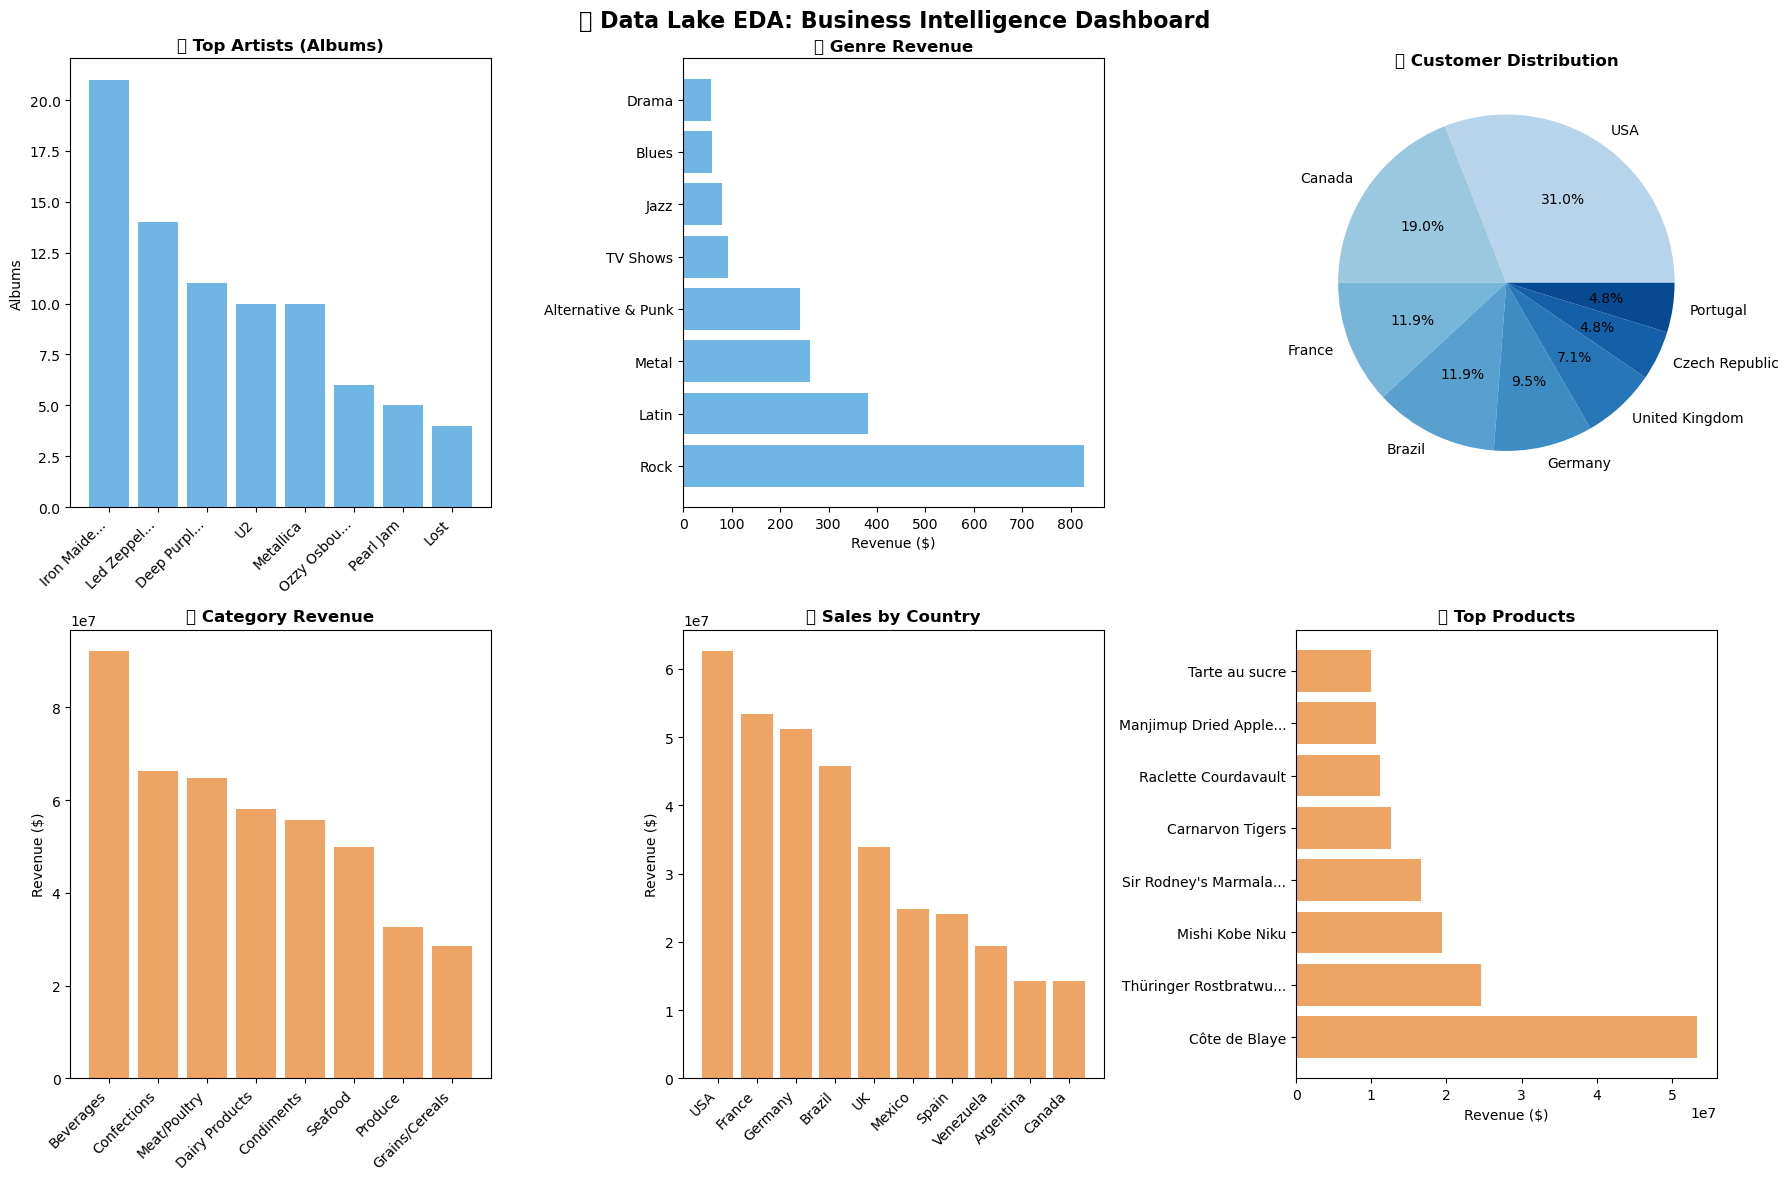

✅ Dashboard Created Successfully


In [20]:
def create_eda_dashboard(chinook_metrics, northwind_metrics):
    """
    Create 6-panel dashboard comparing both databases
    - Top artists vs top products
    - Genre performance vs category performance
    - Customer distribution comparison
    """
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('📊 Data Lake EDA: Business Intelligence Dashboard', 
                 fontsize=16, fontweight='bold')
    
    # Color schemes
    chinook_color = '#3498db'
    northwind_color = '#e67e22'
    
    # Row 1: Chinook Charts
    # 1. Top Artists by Albums
    artists = chinook_metrics['top_artists'].head(8)
    axes[0,0].bar(range(len(artists)), artists['Albums'], 
                  color=chinook_color, alpha=0.7)
    axes[0,0].set_title('🎵 Top Artists (Albums)', fontweight='bold')
    axes[0,0].set_xticks(range(len(artists)))
    axes[0,0].set_xticklabels([name[:10] + '...' if len(name) > 10 else name 
                              for name in artists['Artist']], rotation=45, ha='right')
    axes[0,0].set_ylabel('Albums')
    
    # 2. Genre Revenue Performance
    genres = chinook_metrics['genre_performance'].head(8)
    bars = axes[0,1].barh(range(len(genres)), genres['Revenue'], 
                          color=chinook_color, alpha=0.7)
    axes[0,1].set_title('🎼 Genre Revenue', fontweight='bold')
    axes[0,1].set_yticks(range(len(genres)))
    axes[0,1].set_yticklabels(genres['Genre'])
    axes[0,1].set_xlabel('Revenue ($)')
    
    # 3. Customer Distribution
    customers = chinook_metrics['customer_analysis'].head(8)
    colors_pie = plt.cm.Blues(np.linspace(0.3, 0.9, len(customers)))
    axes[0,2].pie(customers['Customers'], labels=customers['Country'], 
                  autopct='%1.1f%%', colors=colors_pie)
    axes[0,2].set_title('🌍 Customer Distribution', fontweight='bold')
    
    # Row 2: Northwind Charts
    # 4. Category Revenue
    categories = northwind_metrics['category_performance']
    axes[1,0].bar(range(len(categories)), categories['Revenue'], 
                  color=northwind_color, alpha=0.7)
    axes[1,0].set_title('📦 Category Revenue', fontweight='bold')
    axes[1,0].set_xticks(range(len(categories)))
    axes[1,0].set_xticklabels(categories['CategoryName'], rotation=45, ha='right')
    axes[1,0].set_ylabel('Revenue ($)')
    
    # 5. Geographic Sales
    geo = northwind_metrics['geographic_sales'].head(10)
    axes[1,1].bar(range(len(geo)), geo['Revenue'], 
                  color=northwind_color, alpha=0.7)
    axes[1,1].set_title('🌍 Sales by Country', fontweight='bold')
    axes[1,1].set_xticks(range(len(geo)))
    axes[1,1].set_xticklabels(geo['Country'], rotation=45, ha='right')
    axes[1,1].set_ylabel('Revenue ($)')
    
    # 6. Top Products
    products = northwind_metrics['top_products'].head(8)
    axes[1,2].barh(range(len(products)), products['Revenue'], 
                   color=northwind_color, alpha=0.7)
    axes[1,2].set_title('🏆 Top Products', fontweight='bold')
    axes[1,2].set_yticks(range(len(products)))
    axes[1,2].set_yticklabels([name[:20] + '...' if len(name) > 20 else name 
                              for name in products['ProductName']])
    axes[1,2].set_xlabel('Revenue ($)')
    
    plt.tight_layout()
    plt.show()
    
    print("✅ Dashboard Created Successfully")

# Generate the dashboard
print("📈 CREATING VISUALIZATION DASHBOARD")
print("=" * 40)

create_eda_dashboard(chinook_metrics, northwind_metrics)

In [21]:
# ================================================================
# CELL 7: STAR SCHEMA RECOMMENDATIONS
# Purpose: Generate data warehouse design recommendations
# ================================================================

In [22]:
def generate_star_schema_recommendations(chinook_metrics, northwind_metrics):
    """
    Generate star schema design recommendations based on EDA findings
    - Identify optimal fact and dimension tables
    - Recommend measures and business processes
    - Provide implementation guidance
    """
    
    print(f"🎯 STAR SCHEMA DESIGN RECOMMENDATIONS")
    print("=" * 60)
    
    print(f"🎵 CHINOOK STAR SCHEMA:")
    print(f"   Business Process: Music Sales Analysis")
    print(f"   Primary Fact: Fact_MusicSales")
    print(f"   Key Dimensions:")
    print(f"      - Dim_Customer (Geographic segmentation)")
    print(f"      - Dim_Track (Artist → Album → Track hierarchy)")
    print(f"      - Dim_Employee (Sales representative)")
    print(f"      - Dim_Date (Temporal analysis)")
    print(f"   Measures: Revenue, Quantity, UnitPrice")
    print(f"   Focus: {chinook_metrics['kpis']['top_genre']} genre dominates sales")
    
    print(f"\n🏢 NORTHWIND STAR SCHEMA:")
    print(f"   Business Process: Order Sales Analysis")
    print(f"   Primary Fact: Fact_OrderSales")
    print(f"   Key Dimensions:")
    print(f"      - Dim_Customer (Geographic segmentation)")
    print(f"      - Dim_Product (Category → Product hierarchy)")
    print(f"      - Dim_Employee (Territory-based)")
    print(f"      - Dim_Supplier (Supply chain analysis)")
    print(f"      - Dim_Date (Seasonal patterns)")
    print(f"   Measures: Revenue, Quantity, Discount, Freight")
    print(f"   Focus: {northwind_metrics['kpis']['top_category']} category leads market")
    
    print(f"\n💡 IMPLEMENTATION PRIORITIES:")
    print(f"   1. Start with primary fact tables (sales-focused)")
    print(f"   2. Build customer and product dimensions first")
    print(f"   3. Add date dimension for time-series analysis")
    print(f"   4. Consider secondary facts for inventory/shipping")

# Generate recommendations
print("🎯 GENERATING STAR SCHEMA RECOMMENDATIONS")
print("=" * 40)

generate_star_schema_recommendations(chinook_metrics, northwind_metrics)


🎯 GENERATING STAR SCHEMA RECOMMENDATIONS
🎯 STAR SCHEMA DESIGN RECOMMENDATIONS
🎵 CHINOOK STAR SCHEMA:
   Business Process: Music Sales Analysis
   Primary Fact: Fact_MusicSales
   Key Dimensions:
      - Dim_Customer (Geographic segmentation)
      - Dim_Track (Artist → Album → Track hierarchy)
      - Dim_Employee (Sales representative)
      - Dim_Date (Temporal analysis)
   Measures: Revenue, Quantity, UnitPrice
   Focus: Rock genre dominates sales

🏢 NORTHWIND STAR SCHEMA:
   Business Process: Order Sales Analysis
   Primary Fact: Fact_OrderSales
   Key Dimensions:
      - Dim_Customer (Geographic segmentation)
      - Dim_Product (Category → Product hierarchy)
      - Dim_Employee (Territory-based)
      - Dim_Supplier (Supply chain analysis)
      - Dim_Date (Seasonal patterns)
   Measures: Revenue, Quantity, Discount, Freight
   Focus: Beverages category leads market

💡 IMPLEMENTATION PRIORITIES:
   1. Start with primary fact tables (sales-focused)
   2. Build customer and produc

In [23]:
# ================================================================
# CELL 8: EXPORT RESULTS
# Purpose: Save analysis results to CSV files for further use
# ================================================================

In [24]:
def export_eda_results(chinook_quality, northwind_quality, chinook_metrics, northwind_metrics):
    """
    Export key analysis results to CSV files
    - Quality summaries for both databases
    - Business metrics and KPIs
    - Ready for Phase 2 implementation
    """
    
    print(f"💾 EXPORTING ANALYSIS RESULTS")
    print("-" * 30)
    
    exported_files = []
    
    try:
        # Quality summaries
        chinook_quality.to_csv('chinook_quality_summary.csv', index=False)
        exported_files.append('chinook_quality_summary.csv')
        
        northwind_quality.to_csv('northwind_quality_summary.csv', index=False)
        exported_files.append('northwind_quality_summary.csv')
        
        # Chinook business metrics
        chinook_metrics['top_artists'].to_csv('chinook_top_artists.csv', index=False)
        exported_files.append('chinook_top_artists.csv')
        
        chinook_metrics['customer_analysis'].to_csv('chinook_customers.csv', index=False)
        exported_files.append('chinook_customers.csv')
        
        # Northwind business metrics
        northwind_metrics['top_products'].to_csv('northwind_top_products.csv', index=False)
        exported_files.append('northwind_top_products.csv')
        
        northwind_metrics['geographic_sales'].to_csv('northwind_geo_sales.csv', index=False)
        exported_files.append('northwind_geo_sales.csv')
        
        print("✅ Successfully exported files:")
        for i, file in enumerate(exported_files, 1):
            print(f"   {i}. {file}")
            
        print(f"\n📊 Export Summary:")
        print(f"   Quality Reports: 2 files")
        print(f"   Business Metrics: 4 files")
        print(f"   Total Files: {len(exported_files)}")
        
    except Exception as e:
        print(f"❌ Export error: {e}")
        
    return exported_files

# Execute export
exported = export_eda_results(chinook_quality, northwind_quality, chinook_metrics, northwind_metrics)


💾 EXPORTING ANALYSIS RESULTS
------------------------------
✅ Successfully exported files:
   1. chinook_quality_summary.csv
   2. northwind_quality_summary.csv
   3. chinook_top_artists.csv
   4. chinook_customers.csv
   5. northwind_top_products.csv
   6. northwind_geo_sales.csv

📊 Export Summary:
   Quality Reports: 2 files
   Business Metrics: 4 files
   Total Files: 6


In [25]:
# ================================================================
# CELL 9: FINAL SUMMARY AND NEXT STEPS
# Purpose: Summarize complete analysis and prepare for Phase 2
# ================================================================

In [26]:
def generate_final_summary(chinook_quality, northwind_quality, chinook_metrics, northwind_metrics):
    """
    Generate comprehensive summary of EDA analysis
    - Overall quality assessment
    - Key business insights
    - Readiness for next phase
    """
    
    print(f"🎉 EDA ANALYSIS COMPLETE")
    print("=" * 40)
    
    # Quality scores
    chinook_avg_quality = chinook_quality['Quality_Score'].mean()
    northwind_avg_quality = northwind_quality['Quality_Score'].mean()
    
    print(f"📊 ANALYSIS SUMMARY:")
    print(f"   ✅ Data Quality Assessment: Complete")
    print(f"      - Chinook: {chinook_avg_quality:.1f}% average quality")
    print(f"      - Northwind: {northwind_avg_quality:.1f}% average quality")
    print(f"   ✅ Business Intelligence: Complete")
    print(f"      - Chinook: {chinook_metrics['kpis']['customers']} customers analyzed")
    print(f"      - Northwind: {northwind_metrics['kpis']['customers']} customers analyzed")
    print(f"   ✅ Visualizations: 6-panel dashboard created")
    print(f"   ✅ Star Schema: Design recommendations provided")
    print(f"   ✅ Export: 6 CSV files generated")
    
    print(f"\n🎯 KEY FINDINGS:")
    print(f"   🎵 Chinook Highlights:")
    print(f"      - Revenue Leader: {chinook_metrics['kpis']['top_genre']} genre")
    print(f"      - Top Artist: {chinook_metrics['kpis']['top_artist']}")
    print(f"      - Total Revenue: ${chinook_metrics['kpis']['revenue']:,.2f}")
    
    print(f"   🏢 Northwind Highlights:")
    print(f"      - Category Leader: {northwind_metrics['kpis']['top_category']}")
    print(f"      - Top Product: {northwind_metrics['kpis']['top_product'][:30]}...")
    print(f"      - Total Revenue: ${northwind_metrics['kpis']['revenue']:,.2f}")
    
    print(f"\n🚀 READY FOR PHASE 2:")
    print(f"   📋 Next Steps:")
    print(f"      1. Star Schema Implementation")
    print(f"      2. ETL Pipeline Development")
    print(f"      3. Data Warehouse Creation")
    print(f"      4. Analytics Dashboard Building")
    
    print(f"\n📅 Analysis Completed: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# Generate final summary
generate_final_summary(chinook_quality, northwind_quality, chinook_metrics, northwind_metrics)

# Store results for potential Phase 2 use
phase1_results = {
    'chinook_quality': chinook_quality,
    'northwind_quality': northwind_quality,
    'chinook_metrics': chinook_metrics,
    'northwind_metrics': northwind_metrics,
    'exported_files': exported,
    'completion_time': datetime.now()
}

print(f"✅ All results stored in 'phase1_results' variable")
print(f"🎯 Ready to proceed with Phase 2: Star Schema Design")

🎉 EDA ANALYSIS COMPLETE
📊 ANALYSIS SUMMARY:
   ✅ Data Quality Assessment: Complete
      - Chinook: 95.3% average quality
      - Northwind: 97.1% average quality
   ✅ Business Intelligence: Complete
      - Chinook: 45 customers analyzed
      - Northwind: 71 customers analyzed
   ✅ Visualizations: 6-panel dashboard created
   ✅ Star Schema: Design recommendations provided
   ✅ Export: 6 CSV files generated

🎯 KEY FINDINGS:
   🎵 Chinook Highlights:
      - Revenue Leader: Rock genre
      - Top Artist: Iron Maiden
      - Total Revenue: $1,770.92
   🏢 Northwind Highlights:
      - Category Leader: Beverages
      - Top Product: Côte de Blaye...
      - Total Revenue: $343,567,598.38

🚀 READY FOR PHASE 2:
   📋 Next Steps:
      1. Star Schema Implementation
      2. ETL Pipeline Development
      3. Data Warehouse Creation
      4. Analytics Dashboard Building

📅 Analysis Completed: 2025-09-26 01:37:21
✅ All results stored in 'phase1_results' variable
🎯 Ready to proceed with Phase 2: S


### 1.2 การ Mapping ข้อมูล (Source-to-Target Mapping)
ในขั้นตอนนี้ เราจะระบุว่า column ใดจาก Chinook และ Northwind จะถูกแมปไปที่ตาราง Dim/Fact ใหม่  

**ตัวอย่าง Mapping:**  
- Chinook.Customer.CustomerId + Northwind.Customers.CustomerID → **DimCustomer.CustomerID**  
- Chinook.Track.Name + Northwind.Products.ProductName → **DimProduct.ProductName**  
- Chinook.Invoice.InvoiceDate + Northwind.Orders.OrderDate → **DimTime.FullDate**  


In [28]:
# ================================================================
# CELL 1: SOURCE-TO-TARGET MAPPING SETUP
# Purpose: Create mapping functions for data warehouse integration
# ================================================================

In [29]:
def create_dim_customer_mapping():
    """Create DimCustomer mapping table"""
    return pd.DataFrame({
        'Target_Column': [
            'CustomerKey', 'CustomerID', 'CustomerName', 'CompanyName', 
            'City', 'StateRegion', 'Country', 'PostalCode', 'Phone', 'Email'
        ],
        'Chinook_Source': [
            'Generated Surrogate Key',
            '"CH_" + CAST(Customer.CustomerId AS VARCHAR)',
            'Customer.FirstName + " " + Customer.LastName',
            'ISNULL(Customer.Company, "Individual Customer")',
            'Customer.City', 'Customer.State', 'Customer.Country',
            'Customer.PostalCode', 'Customer.Phone', 'Customer.Email'
        ],
        'Northwind_Source': [
            'Generated Surrogate Key',
            '"NW_" + Customers.CustomerID',
            'Customers.ContactName', 'Customers.CompanyName',
            'Customers.City', 'Customers.Region', 'Customers.Country',
            'Customers.PostalCode', 'Customers.Phone', 'NULL'
        ],
        'Transformation_Rule': [
            'Auto-increment surrogate key',
            'Prefix prevents ID collision (CH_/NW_)',
            'Full name for Chinook, contact name for Northwind',
            'Use company name or default for individuals',
            'Direct mapping', 'Map State/Region fields',
            'Direct mapping', 'Direct mapping', 'Direct mapping',
            'Chinook only - Northwind lacks email'
        ]
    })

def create_dim_product_mapping():
    """Create DimProduct mapping table"""
    return pd.DataFrame({
        'Target_Column': [
            'ProductKey', 'ProductID', 'ProductName', 'CategoryName',
            'UnitPrice', 'SupplierInfo', 'ProductType'
        ],
        'Chinook_Source': [
            'Generated Surrogate Key',
            '"CH_" + CAST(Track.TrackId AS VARCHAR)',
            'Track.Name', 'Genre.Name', 'Track.UnitPrice',
            'Artist.Name + " - " + Album.Title', '"Digital Music"'
        ],
        'Northwind_Source': [
            'Generated Surrogate Key',
            '"NW_" + CAST(Products.ProductID AS VARCHAR)',
            'Products.ProductName', 'Categories.CategoryName',
            'Products.UnitPrice', 'Suppliers.CompanyName', '"Physical Product"'
        ],
        'Transformation_Rule': [
            'Auto-increment surrogate key',
            'Prefix prevents ID collision (CH_/NW_)',
            'Track name or product name',
            'Genre maps to category for classification',
            'Standard decimal format',
            'Artist/Album for music, supplier for products',
            'Static classification for BI'
        ]
    })

def create_dim_employee_mapping():
    """Create DimEmployee mapping table"""
    return pd.DataFrame({
        'Target_Column': [
            'EmployeeKey', 'EmployeeID', 'EmployeeName', 'Title',
            'City', 'Country', 'ReportsToKey', 'HireDate'
        ],
        'Chinook_Source': [
            'Generated Surrogate Key',
            '"CH_" + CAST(Employee.EmployeeId AS VARCHAR)',
            'Employee.FirstName + " " + Employee.LastName',
            'Employee.Title', 'Employee.City', 'Employee.Country',
            'Lookup EmployeeKey for Employee.ReportsTo', 'Employee.HireDate'
        ],
        'Northwind_Source': [
            'Generated Surrogate Key',
            '"NW_" + CAST(Employees.EmployeeID AS VARCHAR)',
            'Employees.FirstName + " " + Employees.LastName',
            'Employees.Title', 'Employees.City', 'Employees.Country',
            'Lookup EmployeeKey for Employees.ReportsTo', 'Employees.HireDate'
        ],
        'Transformation_Rule': [
            'Auto-increment surrogate key',
            'Prefix prevents ID collision (CH_/NW_)',
            'Full name concatenation',
            'Direct mapping of job titles',
            'Employee location', 'Employee country',
            'Self-referencing FK for hierarchy', 'Hire date for analysis'
        ]
    })

print("📊 Mapping Functions Created")

📊 Mapping Functions Created


In [30]:
# CELL 2: CREATE TIME AND SOURCE SYSTEM MAPPINGS
# Purpose: Define remaining dimension mappings
# ================================================================

In [31]:
def create_dim_time_mapping():
    """Create DimTime mapping table"""
    return pd.DataFrame({
        'Target_Column': [
            'DateKey', 'FullDate', 'DayOfMonth', 'DayOfWeek',
            'Month', 'Quarter', 'Year', 'IsWeekend'
        ],
        'Chinook_Source': [
            'FORMAT(Invoice.InvoiceDate, "yyyyMMdd")',
            'Invoice.InvoiceDate', 'DAY(Invoice.InvoiceDate)',
            'DATEPART(weekday, Invoice.InvoiceDate)',
            'MONTH(Invoice.InvoiceDate)', 'DATEPART(quarter, Invoice.InvoiceDate)',
            'YEAR(Invoice.InvoiceDate)', 'CASE WHEN DATEPART(weekday, Invoice.InvoiceDate) IN (1,7) THEN 1 ELSE 0 END'
        ],
        'Northwind_Source': [
            'FORMAT(Orders.OrderDate, "yyyyMMdd")',
            'Orders.OrderDate', 'DAY(Orders.OrderDate)',
            'DATEPART(weekday, Orders.OrderDate)',
            'MONTH(Orders.OrderDate)', 'DATEPART(quarter, Orders.OrderDate)',
            'YEAR(Orders.OrderDate)', 'CASE WHEN DATEPART(weekday, Orders.OrderDate) IN (1,7) THEN 1 ELSE 0 END'
        ],
        'Transformation_Rule': [
            'Integer format YYYYMMDD for joins',
            'Standard date format', 'Day 1-31',
            'Weekday 1-7 (Sunday=1)', 'Month 1-12',
            'Quarter 1-4', 'Year for YoY analysis',
            'Weekend flag for analysis'
        ]
    })

def create_dim_source_system_mapping():
    """Create DimSourceSystem mapping table"""
    return pd.DataFrame({
        'Target_Column': ['SourceSystemKey', 'SourceSystemName', 'BusinessDomain'],
        'Chinook_Source': ['1', '"Chinook"', '"Entertainment/Media"'],
        'Northwind_Source': ['2', '"Northwind"', '"Food & Beverage"'],
        'Transformation_Rule': [
            'Static key: 1=Chinook, 2=Northwind',
            'System identifier',
            'Business domain classification'
        ]
    })

def create_fact_sales_mapping():
    """Create FactSales mapping table"""
    return pd.DataFrame({
        'Target_Column': [
            'SalesKey', 'DateKey', 'CustomerKey', 'EmployeeKey',
            'ProductKey', 'SourceSystemKey', 'SalesQuantity', 'SalesAmount'
        ],
        'Chinook_Source': [
            'Generated Surrogate Key',
            'DimTime.DateKey FROM Invoice.InvoiceDate',
            'DimCustomer.CustomerKey FROM Invoice.CustomerId',
            'DimEmployee.EmployeeKey FROM Customer.SupportRepId',
            'DimProduct.ProductKey FROM InvoiceLine.TrackId',
            '1', 'InvoiceLine.Quantity',
            'InvoiceLine.UnitPrice * InvoiceLine.Quantity'
        ],
        'Northwind_Source': [
            'Generated Surrogate Key',
            'DimTime.DateKey FROM Orders.OrderDate',
            'DimCustomer.CustomerKey FROM Orders.CustomerID',
            'DimEmployee.EmployeeKey FROM Orders.EmployeeID',
            'DimProduct.ProductKey FROM [Order Details].ProductID',
            '2', '[Order Details].Quantity',
            '[Order Details].UnitPrice * [Order Details].Quantity * (1 - [Order Details].Discount)'
        ],
        'Transformation_Rule': [
            'Auto-increment fact PK',
            'FK to time dimension',
            'FK to customer dimension',
            'FK to employee dimension',
            'FK to product dimension',
            'FK to source system',
            'Quantity sold',
            'Net amount (Northwind includes discount)'
        ]
    })

print("📊 All Mapping Functions Ready")

📊 All Mapping Functions Ready


In [32]:
# ================================================================
# CELL 3: GENERATE ALL MAPPINGS
# Purpose: Create all mapping tables and display them
# ================================================================

In [33]:
# Create all mapping tables
mapping_tables = {
    'DimCustomer': create_dim_customer_mapping(),
    'DimProduct': create_dim_product_mapping(),
    'DimEmployee': create_dim_employee_mapping(),
    'DimTime': create_dim_time_mapping(),
    'DimSourceSystem': create_dim_source_system_mapping(),
    'FactSales': create_fact_sales_mapping()
}

print("📊 SOURCE-TO-TARGET MAPPING TABLES")
print("=" * 50)

# Display summary for each table
for table_name, mapping_df in mapping_tables.items():
    chinook_sources = sum(1 for x in mapping_df['Chinook_Source'] 
                         if 'NULL' not in str(x) and 'Generated' not in str(x))
    northwind_sources = sum(1 for x in mapping_df['Northwind_Source'] 
                           if 'NULL' not in str(x) and 'Generated' not in str(x))
    
    print(f"\n{table_name}:")
    print(f"  - Total Columns: {len(mapping_df)}")
    print(f"  - Chinook Sources: {chinook_sources}")
    print(f"  - Northwind Sources: {northwind_sources}")

total_columns = sum(len(df) for df in mapping_tables.values())
print(f"\n📊 Overall Statistics:")
print(f"  - Total Tables: {len(mapping_tables)}")
print(f"  - Total Columns: {total_columns}")

📊 SOURCE-TO-TARGET MAPPING TABLES

DimCustomer:
  - Total Columns: 10
  - Chinook Sources: 8
  - Northwind Sources: 8

DimProduct:
  - Total Columns: 7
  - Chinook Sources: 6
  - Northwind Sources: 6

DimEmployee:
  - Total Columns: 8
  - Chinook Sources: 7
  - Northwind Sources: 7

DimTime:
  - Total Columns: 8
  - Chinook Sources: 8
  - Northwind Sources: 8

DimSourceSystem:
  - Total Columns: 3
  - Chinook Sources: 3
  - Northwind Sources: 3

FactSales:
  - Total Columns: 8
  - Chinook Sources: 7
  - Northwind Sources: 7

📊 Overall Statistics:
  - Total Tables: 6
  - Total Columns: 44


In [34]:
# ================================================================
# CELL 4: DISPLAY SAMPLE MAPPINGS
# Purpose: Show detailed mapping examples for key tables
# ================================================================

In [35]:
print("📊 SAMPLE MAPPING DETAILS")
print("=" * 40)

# Show DimCustomer mapping in detail
print("\n🔍 DimCustomer Mapping Sample:")
customer_sample = mapping_tables['DimCustomer'][['Target_Column', 'Chinook_Source', 'Northwind_Source']].head(5)
print(customer_sample.to_string(index=False))

# Show FactSales mapping in detail  
print("\n🔍 FactSales Mapping Sample:")
fact_sample = mapping_tables['FactSales'][['Target_Column', 'Chinook_Source', 'Northwind_Source']].head(5)
print(fact_sample.to_string(index=False))

# Show key transformation challenges
print("\n📊 KEY MAPPING CHALLENGES:")
print("  1. Primary Key Collision: Use CH_/NW_ prefixes")
print("  2. Missing Email in Northwind: Handle with NULL")
print("  3. Different Discount Logic: Chinook=0, Northwind=calculated")
print("  4. State vs Region: Map to unified StateRegion field")
print("  5. Employee Hierarchy: Self-referencing foreign keys")

📊 SAMPLE MAPPING DETAILS

🔍 DimCustomer Mapping Sample:
Target_Column                                  Chinook_Source             Northwind_Source
  CustomerKey                         Generated Surrogate Key      Generated Surrogate Key
   CustomerID    "CH_" + CAST(Customer.CustomerId AS VARCHAR) "NW_" + Customers.CustomerID
 CustomerName    Customer.FirstName + " " + Customer.LastName        Customers.ContactName
  CompanyName ISNULL(Customer.Company, "Individual Customer")        Customers.CompanyName
         City                                   Customer.City               Customers.City

🔍 FactSales Mapping Sample:
Target_Column                                     Chinook_Source                                     Northwind_Source
     SalesKey                            Generated Surrogate Key                              Generated Surrogate Key
      DateKey           DimTime.DateKey FROM Invoice.InvoiceDate                DimTime.DateKey FROM Orders.OrderDate
  CustomerKey  


## ⭐ Task 2: ออกแบบ Kimball Star Schema

ในส่วนนี้ เราจะออกแบบ Star Schema ที่รวมข้อมูลจากทั้งสองระบบ  
ประกอบด้วย
- **FactSales** (เก็บข้อมูลการขายจริง)  
- **Dimension** ต่าง ๆ: DimCustomer, DimEmployee, DimProduct, DimTime, DimSourceSystem  



**สรุป Schema Design**  
- FactSales: เก็บ SalesQuantity, SalesAmount + FK ไปยัง Dimension  
- DimCustomer: รวมลูกค้าจากทั้ง Chinook และ Northwind  
- DimProduct: รวมสินค้า/เพลงจากทั้งสองระบบ  
- DimEmployee: รวมพนักงานจากทั้งสองระบบ  
- DimTime: เก็บมิติด้านเวลา  
- DimSourceSystem: ระบุแหล่งข้อมูล (Chinook / Northwind)  



## 📝 Task 3: การอธิบายข้อมูลและ Business Value

### 3.1 ตัวอย่าง Fact Row Expression
"ในวันที่ **15 มกราคม 2024**, **พนักงาน Nancy Davolio** ได้ขาย **10 หน่วยของสินค้า Chai Tea**  
ให้กับลูกค้า **Bob Johnson** มูลค่ารวม **$180** จากระบบ **Northwind**"

### 3.2 Mock-up Report
ต่อไปเป็นตัวอย่าง Mock-up Dashboard ที่จำลองขึ้นด้วย matplotlib  


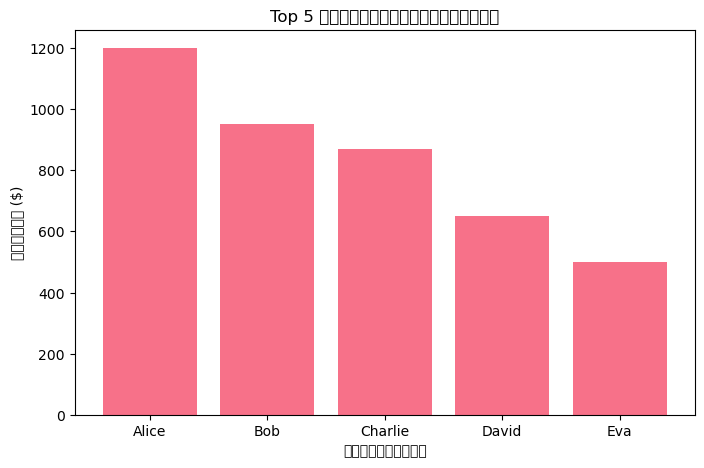

In [39]:

# ======================================
# 📊 Mock-up Report: Top 5 ลูกค้า
# ======================================
import matplotlib.pyplot as plt

customers = ["Alice", "Bob", "Charlie", "David", "Eva"]
sales = [1200, 950, 870, 650, 500]

plt.figure(figsize=(8,5))
plt.bar(customers, sales)
plt.title("Top 5 ลูกค้าตามยอดขายรวม")
plt.xlabel("ชื่อลูกค้า")
plt.ylabel("ยอดขาย ($)")
plt.show()


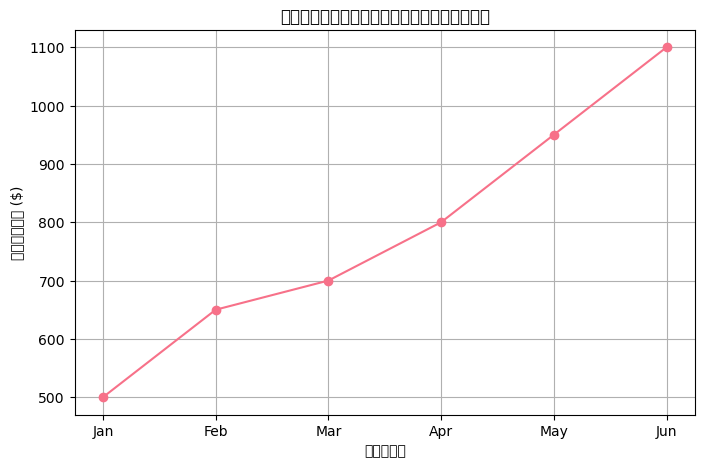

In [40]:

# ======================================
# 📈 Mock-up Report: แนวโน้มยอดขายรายเดือน
# ======================================
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun"]
sales_monthly = [500, 650, 700, 800, 950, 1100]

plt.figure(figsize=(8,5))
plt.plot(months, sales_monthly, marker="o")
plt.title("แนวโน้มยอดขายรายเดือน")
plt.xlabel("เดือน")
plt.ylabel("ยอดขาย ($)")
plt.grid(True)
plt.show()



## 🧠 Task 4: การวิเคราะห์เชิงวิพากษ์และความท้าทายด้าน Data Engineering

### 4.1 ปัญหา Data Ingestion & Integration
- ความต่างของชนิดข้อมูล (int vs string)  
- Primary Key ชนกัน → ต้องใช้ prefix/hashing  
- Missing data (เช่น Region ใน Northwind แต่ไม่มีใน Chinook)  

### 4.2 Schema Evolution
- ถ้ามีบริษัทที่ 3 เข้ามา → สามารถเพิ่ม DimSourceSystem ได้ทันที  
- Star Schema มีความยืดหยุ่นในการขยาย  

### 4.3 Data Lake vs Data Warehouse
- **Data Lake** → เก็บข้อมูลดิบจากทุกแหล่ง (raw zone)  
- **Data Warehouse** → เก็บข้อมูลที่ผ่านการ transform แล้ว (พร้อมวิเคราะห์)  
